In [606]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

pd.options.display.max_rows = 30

two_months_ago = datetime.today() - timedelta(weeks=4)
two_months_foward = datetime.today() + timedelta(weeks=4)

## Reformatação Teste

In [607]:
produtos = requests.get('http://127.0.0.1:5000/produtos').json()

## Test Data Reformat

In [608]:
pedido = produtos[5:30]
pedido = pd.DataFrame(pedido)
pedido['cotacao'] = 14.52
pedido['quantidade'] = 4
pedido.to_json('produtos.json', orient='records')

## Get Pedido

In [609]:
pedido = pd.read_json('produtos.json', orient='records')
pedido['total'] = pedido['cotacao'] * pedido['quantidade']
pedido = pedido[pedido['marca'] != '']
pedido = pd.pivot_table(pedido, values=['total'], index='marca', aggfunc='sum').reset_index()

pedido

,marca,total
0,1953,58.08
1,ARG,58.08
2,Alimentar,58.08
3,Bassi,58.08
4,Burg,58.08
5,Cara Preta,232.32
6,Dia a Dia,58.08
7,Ester de Lima,58.08
8,Estância 92,116.16
9,Jerônimos,116.16


## Agendamento

In [610]:
# prazos
prazos = pd.read_csv('prazos.csv')
prazos.columns = ['marca',1,2,3]
prazos['n_parcelas'] = 3 - prazos.T.isna().sum()
prazos = prazos.merge(pedido)

prazos

,marca,1,2,3,n_parcelas,total
0,Alimentar,14.0,NaN,NaN,1,58.08
1,Cara Preta,7.0,14.0,NaN,2,232.32
2,Ester de Lima,7.0,14.0,NaN,2,58.08
3,Estância 92,14.0,21.0,28.0,3,116.16
4,Jerônimos,7.0,14.0,NaN,2,116.16
5,Porcão,7.0,14.0,NaN,2,58.08
6,Porcão,7.0,14.0,NaN,2,58.08
7,Minerva,14.0,21.0,28.0,3,174.24
8,Recheados Brasil,7.0,14.0,NaN,2,116.16


In [611]:
# agenda
agenda = prazos.copy()
agenda
for parcela in [1,2,3]:
    agenda[parcela] = [datetime.today() + timedelta(days=x) if x > 0 else None for x in prazos[parcela]]
agenda['valor'] = agenda['total']/agenda['n_parcelas']
agenda = agenda.melt(id_vars=['marca', 'valor'], value_vars=[1,2,3], value_name='data', var_name='parcela').dropna()
agenda

,marca,valor,parcela,data
0,Alimentar,58.08,1,2022-06-12 18:26:39.853966
1,Cara Preta,116.16,1,2022-06-05 18:26:39.853966
2,Ester de Lima,29.04,1,2022-06-05 18:26:39.853966
3,Estância 92,38.72,1,2022-06-12 18:26:39.853966
4,Jerônimos,58.08,1,2022-06-05 18:26:39.853966
5,Porcão,29.04,1,2022-06-05 18:26:39.853966
6,Porcão,29.04,1,2022-06-05 18:26:39.853966
7,Minerva,58.08,1,2022-06-12 18:26:39.853966
8,Recheados Brasil,58.08,1,2022-06-05 18:26:39.853966
10,Cara Preta,116.16,2,2022-06-12 18:26:39.854961


In [612]:
# peso
peso = agenda.copy()
peso.index = peso.set_index('data').index.strftime('%d/%m')
peso = pd.pivot_table(agenda, index=peso.index, aggfunc='sum').reset_index()
peso


,data,valor
0,05/06,319.44
1,12/06,474.32
2,19/06,96.80
3,26/06,96.80


## Situação Atual

In [613]:
# contas
vendas = list()
data = {
    'formato': 'json',
    'token': '2b6fc7102240cedcc9166c43921ea73eea82b876',
    'dataInicial': two_months_ago.strftime('%d/%m/%Y'),
    'dataFinal': datetime.today().strftime('%d/%m/%Y'),
    'pagina': 1
}
while True:
    try:

        url = 'https://api.tiny.com.br/api2/pedidos.pesquisa.php'
        vendas += [x['pedido'] for x in requests.post(url, data).json()['retorno']['pedidos']]
        data['pagina'] += 1
    except:
        break
vendas = pd.DataFrame(vendas)


In [ ]:
# faturamento diário
faturamento_estimado = vendas['valor'].sum()/30
faturamento_estimado

3997.358

In [ ]:
# contas
contas = list()
data = {
    'formato': 'json',
    'token': '2b6fc7102240cedcc9166c43921ea73eea82b876',
    'data_ini_vencimento': datetime.today().strftime('%d/%m/%Y'),
    'data_fim_vencimento': two_months_foward.strftime('%d/%m/%Y'),
    'pagina': 1
}
while True:
    try:
        url = 'https://api.tiny.com.br/api2/contas.pagar.pesquisa.php'
        contas += [x['conta'] for x in requests.post(url, data).json()['retorno']['contas']]
        data['pagina'] += 1
    except:
        break
contas = pd.DataFrame(contas)
contas

""


## Plotagem

Text(0.5, 1.0, 'Compras')

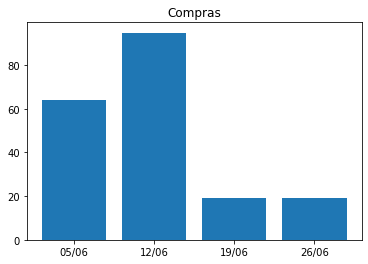

In [ ]:
# compras
x = peso['data']
y = peso['valor']/5

plt.bar(x, y)
plt.title('Compras')

<BarContainer object of 4 artists>

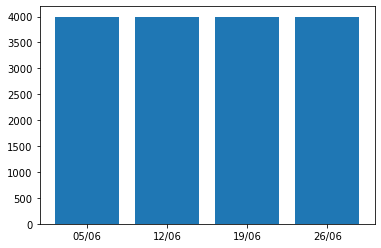

In [ ]:
# faturamento
y = faturamento_estimado
x = peso['data']

plt.bar(x, y)